#### Estrutura:

- Array com todas as técnicas para avaliação
- Função para avaliar predição da técnica
- Função para percorrer cada ação, realizar split dos dados em train e test, e enviar os dados para a função de predição e avaliação
- Função para gravar em csv todas as atividades

Lembrar de criar logs para todas as etapas e gravar em .csv


A fazer:
- Colocar o maximo possível de técnicas de classificação
- Verificar viabilidade de realizar gridsearch pra cada tecnica


In [3]:
import pandas as pd
import time
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
#from sklearn import tree, svm, naive_bayes, neighbors, ensemble
#from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

#from sklearn.base import ClassifierMixin
#from sklearn.utils.testing import all_estimators

import autosklearn.classification
#from tpot import TPOTClassifier


from joblib import Parallel, delayed
import multiprocessing


%matplotlib inline

Using TensorFlow backend.


In [4]:
dados = pd.read_csv('../dados/dados_tratados_acoes_atuais.csv')

dados.head()

,DATA,CODNEG,STATUS_POSITIVO,epoch,day_of_week,day_of_month,day_of_quarter,day_of_year,week_of_month,week_of_year,...,quarter_actual,year_actual,first_day_of_week,last_day_of_week,first_day_of_month,last_day_of_month,first_day_of_quarter,last_day_of_quarter,first_day_of_year,last_day_of_year
0,20080102,ABCB4,-1,1199232000,3,2,2,2,1,1,...,1,2008,20071231,20080106,20080101,20080131,20080101,20080331,20080101,20081231
1,20080102,ABCB4F,1,1199232000,3,2,2,2,1,1,...,1,2008,20071231,20080106,20080101,20080131,20080101,20080331,20080101,20081231
2,20080102,AELP3,1,1199232000,3,2,2,2,1,1,...,1,2008,20071231,20080106,20080101,20080131,20080101,20080331,20080101,20081231
3,20080102,AGRO3,1,1199232000,3,2,2,2,1,1,...,1,2008,20071231,20080106,20080101,20080131,20080101,20080331,20080101,20081231
4,20080102,ALPA4,-1,1199232000,3,2,2,2,1,1,...,1,2008,20071231,20080106,20080101,20080131,20080101,20080331,20080101,20081231


Array contendo todas as técnicas para realizar a avaliação.

Caso queira retirar ou acrescentar alguma técnica para a realização do teste de avaliação, basta modificar este array acrescentando ou retirando a técnica.

In [5]:
def baseline_model():
    model = Sequential()
    model.add(Dense(90, input_dim=19, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(90, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
    return model

In [6]:
tecnicas = [ ('AdaBoostClassifier', sklearn.ensemble.weight_boosting.AdaBoostClassifier()),
             ('BaggingClassifier', sklearn.ensemble.bagging.BaggingClassifier()),
             ('BernoulliNB', sklearn.naive_bayes.BernoulliNB()),
             #('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
             ('DecisionTreeClassifier', sklearn.tree.tree.DecisionTreeClassifier()),
             ('ExtraTreeClassifier', sklearn.tree.tree.ExtraTreeClassifier()),
             ('ExtraTreesClassifier', sklearn.ensemble.forest.ExtraTreesClassifier()),
             ('GaussianNB', sklearn.naive_bayes.GaussianNB()),
             #('GaussianProcessClassifier', sklearn.gaussian_process.gpc.GaussianProcessClassifier),
             ('GradientBoostingClassifier', sklearn.ensemble.gradient_boosting.GradientBoostingClassifier()),
             ('KNeighborsClassifier', sklearn.neighbors.classification.KNeighborsClassifier()),
             #('LabelPropagation', sklearn.semi_supervised.label_propagation.LabelPropagation),
             #('LabelSpreading', sklearn.semi_supervised.label_propagation.LabelSpreading),
             #('LinearDiscriminantAnalysis', sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
             ('LinearSVC', sklearn.svm.classes.LinearSVC()),
             ('LogisticRegression', sklearn.linear_model.logistic.LogisticRegression()),
             ('LogisticRegressionCV', sklearn.linear_model.logistic.LogisticRegressionCV()),
             ('MLPClassifier', sklearn.neural_network.multilayer_perceptron.MLPClassifier()),
             ('MultinomialNB', sklearn.naive_bayes.MultinomialNB()),
             ('NearestCentroid', sklearn.neighbors.nearest_centroid.NearestCentroid()),
             #('NuSVC', sklearn.svm.classes.NuSVC), 
             ('PassiveAggressiveClassifier', sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier()),
             ('Perceptron', sklearn.linear_model.perceptron.Perceptron()),
             #('QuadraticDiscriminantAnalysis', sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis),
             #('RadiusNeighborsClassifier', sklearn.neighbors.classification.RadiusNeighborsClassifier),
             ('RandomForestClassifier', sklearn.ensemble.forest.RandomForestClassifier()),
             ('RidgeClassifier', sklearn.linear_model.ridge.RidgeClassifier()),
             ('RidgeClassifierCV', sklearn.linear_model.ridge.RidgeClassifierCV()),
             ('SGDClassifier', sklearn.linear_model.stochastic_gradient.SGDClassifier()),
             ('SVC', sklearn.svm.classes.SVC())#,
             #('KerasClassifier', KerasClassifier(build_fn=baseline_model, verbose=0, batch_size=10, epochs=50))
           ]

len(tecnicas)

/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/anaconda3/lib/python3.6/s

22

In [7]:
acoes = dados.CODNEG.unique()
len(acoes)

1237

In [8]:
# Função para retornar os dados da ação

def retornaDadosAcao(acao):
    return dados.loc[dados['CODNEG'] == acao]

In [9]:
def splitDados(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    return X_train, X_test, y_train, y_test

In [10]:
# Dataframe que vai armazenar os resultados das técnicas
colunas_resultado = ['Ação', 'Técnica', 'Acurácia']
resultadosTecnicas = pd.DataFrame(columns=colunas_resultado)

In [11]:
def avaliarTecnica(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    #print(accuracy)
    #global resultadosTecnicas
    #resultadosTecnicas = resultadosTecnicas.append(pd.DataFrame([[acao, tecnica, accuracy]], columns=colunas_resultado))
    return accuracy

In [12]:
def treinarTecnicas(acao, X_train, X_test, y_train, y_test):
    resultados = []
    
    for tecnica, model in tecnicas:
        #model = model()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acuracia = avaliarTecnica(y_test, y_pred)
        print('Ação: ' + str(acao) + ', Técnica: ' + str(tecnica) + ', Acurácia: ' + str(acuracia))
        resultados.append([acao, tecnica, acuracia])
        
    return resultados

In [13]:

# Percorrer todas as ações
def executarTecnicas(acao):

    #print(acao)
    # Coletar dados da ação
    dados_acao = retornaDadosAcao(acao)
    
    # Separar dados em X e y
    X = dados_acao.copy()
    X.drop('CODNEG', axis=1, inplace=True)
    X.drop('STATUS_POSITIVO', axis=1, inplace=True)
    #X = dados_acao.drop(['CODNEG', 'STATUS_POSITIVO'], axis = 1)
    y = dados_acao['STATUS_POSITIVO']
    
    # Limpar mémoria apagando váriavel que não será mais utilizada
    del(dados_acao)
    
    # Realizar split dos dados
    X_train, X_test, y_train, y_test = splitDados(X, y)
    
    # Limpar mémoria apagando váriavel que não será mais utilizada
    del(X)
    del(y)
    
    # Verificar se existe apenas "positivo" ou apenas "negativo" no target
    if (len(y_train.unique()) > 1) and (len(y_test.unique()) > 1):        
    
        #X_train = X_train.as_matrix()
        #X_test = X_test.as_matrix()
    
        # Treinar e avaliar técnicas
        resultados = treinarTecnicas(acao, X_train, X_test, y_train, y_test)
        return resultados
        
    else:
        print('Entrei exceção, ação: ' + str(acao))
    

In [14]:
start_time = time.time()

# Limpando dataframe que armazena resultados das avaliações
resultadosTecnicas.drop(resultadosTecnicas.index, inplace=True)

#, backend="threading"
resultados = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(executarTecnicas)(acao) for acao in acoes)

for resultado in resultados:
    resultadosTecnicas = resultadosTecnicas.append(pd.DataFrame(resultado, columns=colunas_resultado))

print("---Tempo gasto:  %s minutos ---" % ((time.time() - start_time) / 60))

Ação: ABCB4F, Técnica: AdaBoostClassifier, Acurácia: 0.514583333333
Ação: AGRO3, Técnica: AdaBoostClassifier, Acurácia: 0.599605522682
Ação: ABCB4, Técnica: AdaBoostClassifier, Acurácia: 0.537878787879
Ação: AELP3, Técnica: AdaBoostClassifier, Acurácia: 0.62479338843
Ação: ABCB4F, Técnica: BaggingClassifier, Acurácia: 0.5125
Ação: AGRO3, Técnica: BaggingClassifier, Acurácia: 0.573964497041
Ação: ABCB4F, Técnica: BernoulliNB, Acurácia: 0.514583333333
Ação: AGRO3, Técnica: BernoulliNB, Acurácia: 0.577909270217
Ação: ABCB4F, Técnica: DecisionTreeClassifier, Acurácia: 0.504166666667
Ação: AELP3, Técnica: BaggingClassifier, Acurácia: 0.613223140496
Ação: ABCB4F, Técnica: ExtraTreeClassifier, Acurácia: 0.4875
Ação: ABCB4, Técnica: BaggingClassifier, Acurácia: 0.549242424242
Ação: AGRO3, Técnica: DecisionTreeClassifier, Acurácia: 0.571992110454
Ação: AELP3, Técnica: BernoulliNB, Acurácia: 0.611570247934
Ação: AGRO3, Técnica: ExtraTreeClassifier, Acurácia: 0.593688362919
Ação: ABCB4, Técnica: 

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.8697869234662686e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: ALPA4F, Técnica: RidgeClassifier, Acurácia: 0.613698630137
Ação: ALPA4, Técnica: RidgeClassifierCV, Acurácia: 0.453409090909
Ação: ALPA4F, Técnica: RidgeClassifierCV, Acurácia: 0.382191780822
Ação: ALPA4, Técnica: SGDClassifier, Acurácia: 0.404545454545
Ação: ALPA4F, Técnica: SGDClassifier, Acurácia: 0.386301369863
Ação: BBAS3, Técnica: LinearSVC, Acurácia: 0.515515515516
Ação: BAZA3F, Técnica: SVC, Acurácia: 0.737237237237
Ação: BBAS3, Técnica: LogisticRegression, Acurácia: 0.468468468468
Ação: ALPA4F, Técnica: SVC, Acurácia: 0.613698630137
Ação: BBAS3F, Técnica: AdaBoostClassifier, Acurácia: 0.533684210526
Ação: BBAS3, Técnica: LogisticRegressionCV, Acurácia: 0.468468468468
Ação: ALPA4, Técnica: SVC, Acurácia: 0.595454545455
Ação: BBAS3, Técnica: MLPClassifier, Acurácia: 0.484484484484
Ação: BBAS3, Técnica: MultinomialNB, Acurácia: 0.469469469469
Ação: BBAS3, Técnica: NearestCentroid, Acurácia: 0.469469469469
Ação: BBAS3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.484484

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.995241721616927e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: BMIN4, Técnica: RidgeClassifier, Acurácia: 0.668041237113
Ação: BMIN4, Técnica: RidgeClassifierCV, Acurácia: 0.546391752577
Ação: BMIN4, Técnica: SGDClassifier, Acurácia: 0.668041237113
Ação: BNBR3, Técnica: LogisticRegressionCV, Acurácia: 0.787610619469
Ação: BNBR3, Técnica: MLPClassifier, Acurácia: 0.787610619469
Ação: BNBR3, Técnica: MultinomialNB, Acurácia: 0.504424778761
Ação: BNBR3, Técnica: NearestCentroid, Acurácia: 0.504424778761
Ação: BNBR3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.212389380531
Ação: BNBR3, Técnica: Perceptron, Acurácia: 0.787610619469
Ação: BNBR3, Técnica: RandomForestClassifier, Acurácia: 0.752212389381
Ação: BNBR3, Técnica: RidgeClassifier, Acurácia: 0.787610619469
Ação: BNBR3, Técnica: RidgeClassifierCV, Acurácia: 0.5
Ação: BNBR3, Técnica: SGDClassifier, Acurácia: 0.787610619469
Ação: BNBR3, Técnica: SVC, Acurácia: 0.787610619469
Ação: BMIN4, Técnica: SVC, Acurácia: 0.668041237113
Ação: BMEB4, Técnica: SVC, Acurácia: 0.702317290553
Ação: BO

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.249192252818791e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: BOBR4, Técnica: RidgeClassifier, Acurácia: 0.515752625438
Ação: BOBR4, Técnica: RidgeClassifierCV, Acurácia: 0.548424737456
Ação: BOBR4, Técnica: SGDClassifier, Acurácia: 0.469078179697
Ação: BRAP3F, Técnica: RandomForestClassifier, Acurácia: 0.53873659118
Ação: BRAP4, Técnica: LogisticRegressionCV, Acurácia: 0.497732426304
Ação: BRAP3F, Técnica: RidgeClassifier, Acurácia: 0.609058402861
Ação: BRAP3F, Técnica: RidgeClassifierCV, Acurácia: 0.53516090584
Ação: BRAP3F, Técnica: SGDClassifier, Acurácia: 0.618593563766
Ação: BRAP4, Técnica: MLPClassifier, Acurácia: 0.488662131519
Ação: BRAP4, Técnica: MultinomialNB, Acurácia: 0.478458049887
Ação: BRAP4, Técnica: NearestCentroid, Acurácia: 0.478458049887
Ação: BRAP4, Técnica: PassiveAggressiveClassifier, Acurácia: 0.488662131519
Ação: BRAP4, Técnica: Perceptron, Acurácia: 0.511337868481
Ação: BRAP4, Técnica: RandomForestClassifier, Acurácia: 0.520408163265
Ação: BRAP4, Técnica: RidgeClassifier, Acurácia: 0.475056689342
Ação: BRAP4, Téc

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.189082870211959e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: BRAP4F, Técnica: RidgeClassifier, Acurácia: 0.5
Ação: BRAP4F, Técnica: RidgeClassifierCV, Acurácia: 0.508120649652
Ação: BRAP4F, Técnica: SGDClassifier, Acurácia: 0.505800464037
Ação: BRIV3, Técnica: SVC, Acurácia: 0.848197343454
Ação: BRIV4, Técnica: RandomForestClassifier, Acurácia: 0.745714285714
Ação: BRIV4, Técnica: RidgeClassifier, Acurácia: 0.79
Ação: BRIV4, Técnica: RidgeClassifierCV, Acurácia: 0.548571428571
Ação: BRIV4, Técnica: SGDClassifier, Acurácia: 0.79
Ação: BRAP4T, Técnica: LinearSVC, Acurácia: 0.816639741519
Ação: BRAP4T, Técnica: LogisticRegression, Acurácia: 0.816639741519
Ação: BRKM3, Técnica: AdaBoostClassifier, Acurácia: 0.653543307087
Ação: BRAP4T, Técnica: LogisticRegressionCV, Acurácia: 0.816639741519
Ação: BRKM3, Técnica: BaggingClassifier, Acurácia: 0.596850393701
Ação: BRKM3, Técnica: BernoulliNB, Acurácia: 0.659842519685
Ação: BRIV4, Técnica: SVC, Acurácia: 0.79
Ação: BRKM3, Técnica: DecisionTreeClassifier, Acurácia: 0.625196850394
Ação: BRKM3, Técni

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.563244142967613e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: BRKM3F, Técnica: RidgeClassifier, Acurácia: 0.771676300578
Ação: BRKM3F, Técnica: RidgeClassifierCV, Acurácia: 0.488439306358
Ação: BRKM3F, Técnica: SGDClassifier, Acurácia: 0.771676300578
Ação: BRKM3F, Técnica: SVC, Acurácia: 0.771676300578
Ação: BRKM3, Técnica: MLPClassifier, Acurácia: 0.368503937008
Ação: BRKM3, Técnica: MultinomialNB, Acurácia: 0.544881889764
Ação: BRKM3, Técnica: NearestCentroid, Acurácia: 0.544881889764
Ação: BRKM3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.659842519685
Ação: BRKM3, Técnica: Perceptron, Acurácia: 0.659842519685
Ação: BRKM3, Técnica: RandomForestClassifier, Acurácia: 0.584251968504
Ação: BRKM3, Técnica: RidgeClassifier, Acurácia: 0.656692913386
Ação: BRKM5, Técnica: GradientBoostingClassifier, Acurácia: 0.532051282051
Ação: BRKM3, Técnica: RidgeClassifierCV, Acurácia: 0.546456692913
Ação: BRKM5, Técnica: KNeighborsClassifier, Acurácia: 0.566666666667
Ação: BRKM3, Técnica: SGDClassifier, Acurácia: 0.659842519685
Ação: BRKM5F, Técnica:

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.8670223796412576e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: CCRO3, Técnica: RidgeClassifier, Acurácia: 0.493670886076
Ação: CCRO3, Técnica: RidgeClassifierCV, Acurácia: 0.550632911392
Ação: CCRO3, Técnica: SGDClassifier, Acurácia: 0.46835443038
Ação: CESP3, Técnica: LogisticRegressionCV, Acurácia: 0.572486772487
Ação: CCRO3T, Técnica: LogisticRegressionCV, Acurácia: 0.830939226519
Ação: CCRO3F, Técnica: SVC, Acurácia: 0.472259810555
Ação: CCRO3T, Técnica: MLPClassifier, Acurácia: 0.830939226519
Ação: CCRO3T, Técnica: MultinomialNB, Acurácia: 0.53591160221
Ação: CCRO3T, Técnica: NearestCentroid, Acurácia: 0.533701657459
Ação: CCRO3T, Técnica: PassiveAggressiveClassifier, Acurácia: 0.830939226519
Ação: CCRO3T, Técnica: Perceptron, Acurácia: 0.830939226519
Ação: CCRO3T, Técnica: RandomForestClassifier, Acurácia: 0.767955801105
Ação: CCRO3T, Técnica: RidgeClassifier, Acurácia: 0.830939226519
Ação: CCRO3T, Técnica: RidgeClassifierCV, Acurácia: 0.477348066298
Ação: CESP3, Técnica: MLPClassifier, Acurácia: 0.562962962963
Ação: CCRO3T, Técnica: S

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.700551686314778e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: CMIG4T, Técnica: RidgeClassifier, Acurácia: 0.786952089704
Ação: CMIG4T, Técnica: RidgeClassifierCV, Acurácia: 0.53618756371
Ação: CPFE3F, Técnica: DecisionTreeClassifier, Acurácia: 0.462222222222
Ação: CMIG4T, Técnica: SGDClassifier, Acurácia: 0.786952089704
Ação: CPFE3F, Técnica: ExtraTreeClassifier, Acurácia: 0.506666666667
Ação: CPFE3F, Técnica: ExtraTreesClassifier, Acurácia: 0.505185185185
Ação: CPFE3F, Técnica: GaussianNB, Acurácia: 0.468148148148
Ação: CPLE3, Técnica: AdaBoostClassifier, Acurácia: 0.581039755352
Ação: CPFE3, Técnica: SVC, Acurácia: 0.505917159763
Ação: CPFE3F, Técnica: GradientBoostingClassifier, Acurácia: 0.500740740741
Ação: CPFE3F, Técnica: KNeighborsClassifier, Acurácia: 0.522962962963
Ação: CPLE3, Técnica: BaggingClassifier, Acurácia: 0.528032619776
Ação: CPLE3, Técnica: BernoulliNB, Acurácia: 0.545361875637
Ação: CPLE3, Técnica: DecisionTreeClassifier, Acurácia: 0.517838939857
Ação: CPLE3, Técnica: ExtraTreeClassifier, Acurácia: 0.538226299694
Ação:

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Ação: CSNA3, Técnica: LinearSVC, Acurácia: 0.527
Ação: CSNA3, Técnica: LogisticRegression, Acurácia: 0.516
Ação: CSRN6, Técnica: LogisticRegressionCV, Acurácia: 0.972222222222
Ação: CSRN6, Técnica: MLPClassifier, Acurácia: 0.972222222222
Ação: CSRN6, Técnica: MultinomialNB, Acurácia: 0.833333333333
Ação: CSRN6, Técnica: NearestCentroid, Acurácia: 0.833333333333
Ação: CSRN6, Técnica: PassiveAggressiveClassifier, Acurácia: 0.972222222222
Ação: CSRN6, Técnica: Perceptron, Acurácia: 0.972222222222
Ação: CSRN6, Técnica: RandomForestClassifier, Acurácia: 0.972222222222
Ação: CSRN6, Técnica: RidgeClassifier, Acurácia: 0.972222222222
Ação: CSRN6, Técnica: RidgeClassifierCV, Acurácia: 0.916666666667
Ação: CSRN6, Técnica: SGDClassifier, Acurácia: 0.0277777777778
Ação: CSRN6, Técnica: SVC, Acurácia: 0.972222222222
Ação: CSNA3F, Técnica: MLPClassifier, Acurácia: 0.493657505285
Ação: CSNA3F, Técnica: MultinomialNB, Acurácia: 0.498942917548
Ação: CSNA3F, Técnica: NearestCentroid, Acurácia: 0.4989429

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.565944886940859e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: DASA3, Técnica: KNeighborsClassifier, Acurácia: 0.537337662338
Ação: CYRE3T, Técnica: RidgeClassifier, Acurácia: 0.790996784566
Ação: CYRE3T, Técnica: RidgeClassifierCV, Acurácia: 0.524115755627
Ação: CYRE3T, Técnica: SGDClassifier, Acurácia: 0.721329046088
Ação: DASA3, Técnica: LinearSVC, Acurácia: 0.50974025974
Ação: DASA3, Técnica: LogisticRegression, Acurácia: 0.534090909091
Ação: DASA3F, Técnica: AdaBoostClassifier, Acurácia: 0.582897033159
Ação: DASA3, Técnica: LogisticRegressionCV, Acurácia: 0.534090909091
Ação: DASA3F, Técnica: BaggingClassifier, Acurácia: 0.56369982548
Ação: DASA3F, Técnica: BernoulliNB, Acurácia: 0.589877835951
Ação: DASA3F, Técnica: DecisionTreeClassifier, Acurácia: 0.532286212914
Ação: DASA3F, Técnica: ExtraTreeClassifier, Acurácia: 0.525305410122
Ação: DASA3F, Técnica: ExtraTreesClassifier, Acurácia: 0.534031413613
Ação: DASA3, Técnica: MLPClassifier, Acurácia: 0.534090909091
Ação: DASA3F, Técnica: GaussianNB, Acurácia: 0.493891797557
Ação: DASA3, Té

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.72336973708793e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: ELET3F, Técnica: RidgeClassifier, Acurácia: 0.524762908325
Ação: ELET6, Técnica: ExtraTreesClassifier, Acurácia: 0.529470529471
Ação: ELET3F, Técnica: RidgeClassifierCV, Acurácia: 0.515279241307
Ação: ELET6, Técnica: GaussianNB, Acurácia: 0.474525474525
Ação: ELET3F, Técnica: SGDClassifier, Acurácia: 0.530031612223
Ação: ELET3T, Técnica: LinearSVC, Acurácia: 0.806591031875
Ação: ELET3T, Técnica: LogisticRegression, Acurácia: 0.806591031875
Ação: ELET6F, Técnica: GradientBoostingClassifier, Acurácia: 0.520504731861
Ação: ELET6F, Técnica: KNeighborsClassifier, Acurácia: 0.524710830705
Ação: ELET3T, Técnica: LogisticRegressionCV, Acurácia: 0.806591031875
Ação: ELET6, Técnica: GradientBoostingClassifier, Acurácia: 0.537462537463
Ação: ELET6, Técnica: KNeighborsClassifier, Acurácia: 0.516483516484
Ação: ELET3F, Técnica: SVC, Acurácia: 0.530031612223
Ação: ELET6F, Técnica: LinearSVC, Acurácia: 0.534174553102
Ação: ELET6F, Técnica: LogisticRegression, Acurácia: 0.49316508938
Ação: ELET6

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4546811639153417e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: FESA4, Técnica: RidgeClassifier, Acurácia: 0.568131868132
Ação: FESA4, Técnica: RidgeClassifierCV, Acurácia: 0.563736263736
Ação: FESA4, Técnica: SGDClassifier, Acurácia: 0.554945054945
Ação: FESA4F, Técnica: LinearSVC, Acurácia: 0.650154798762
Ação: FESA4F, Técnica: LogisticRegression, Acurácia: 0.637770897833
Ação: FHER3F, Técnica: LinearSVC, Acurácia: 0.573304157549
Ação: FHER3F, Técnica: LogisticRegression, Acurácia: 0.557986870897
Ação: FHER3, Técnica: LinearSVC, Acurácia: 0.457350272232
Ação: FHER3, Técnica: LogisticRegression, Acurácia: 0.542649727768
Ação: FESA4F, Técnica: LogisticRegressionCV, Acurácia: 0.637770897833
Ação: FHER3F, Técnica: LogisticRegressionCV, Acurácia: 0.560175054705
Ação: FESA4F, Técnica: MLPClassifier, Acurácia: 0.650154798762
Ação: FESA4F, Técnica: MultinomialNB, Acurácia: 0.592879256966
Ação: FESA4F, Técnica: NearestCentroid, Acurácia: 0.592879256966
Ação: FESA4F, Técnica: PassiveAggressiveClassifier, Acurácia: 0.650154798762
Ação: FESA4F, Técnica

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.60292821634287e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: FNAM11, Técnica: RidgeClassifier, Acurácia: 0.844362745098
Ação: FNAM11, Técnica: RidgeClassifierCV, Acurácia: 0.502450980392
Ação: FNAM11, Técnica: SGDClassifier, Acurácia: 0.844362745098
Ação: FNAM11F, Técnica: BaggingClassifier, Acurácia: 0.782997762864
Ação: FNAM11F, Técnica: BernoulliNB, Acurácia: 0.845637583893
Ação: FNAM11F, Técnica: DecisionTreeClassifier, Acurácia: 0.765100671141
Ação: FNAM11F, Técnica: ExtraTreeClassifier, Acurácia: 0.762863534676
Ação: FNAM11F, Técnica: ExtraTreesClassifier, Acurácia: 0.798657718121
Ação: FNAM11F, Técnica: GaussianNB, Acurácia: 0.749440715884
Ação: FNOR11, Técnica: AdaBoostClassifier, Acurácia: 0.765847347995
Ação: FNAM11F, Técnica: GradientBoostingClassifier, Acurácia: 0.847874720358
Ação: FNAM11F, Técnica: KNeighborsClassifier, Acurácia: 0.845637583893
Ação: FNOR11, Técnica: BaggingClassifier, Acurácia: 0.685640362225
Ação: FNOR11, Técnica: BernoulliNB, Acurácia: 0.765847347995
Ação: FNAM11F, Técnica: LinearSVC, Acurácia: 0.845637583

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.853869693228987e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: GOAU3, Técnica: RidgeClassifier, Acurácia: 0.584382871537
Ação: GOAU3, Técnica: RidgeClassifierCV, Acurácia: 0.578085642317
Ação: GOAU3, Técnica: SGDClassifier, Acurácia: 0.406801007557
Ação: GGBR4F, Técnica: SVC, Acurácia: 0.516317016317
Ação: GGBR4, Técnica: SVC, Acurácia: 0.502331002331
Ação: GGBR4T, Técnica: GradientBoostingClassifier, Acurácia: 0.751617541337
Ação: GOAU3F, Técnica: AdaBoostClassifier, Acurácia: 0.67969924812
Ação: GGBR4T, Técnica: KNeighborsClassifier, Acurácia: 0.719985621855
Ação: GOAU3, Técnica: SVC, Acurácia: 0.593198992443
Ação: GOAU3F, Técnica: BaggingClassifier, Acurácia: 0.640601503759
Ação: GOAU3F, Técnica: BernoulliNB, Acurácia: 0.675187969925
Ação: GOAU3F, Técnica: DecisionTreeClassifier, Acurácia: 0.618045112782
Ação: GOAU3F, Técnica: ExtraTreeClassifier, Acurácia: 0.654135338346
Ação: GOAU3F, Técnica: ExtraTreesClassifier, Acurácia: 0.628571428571
Ação: GOAU3F, Técnica: GaussianNB, Acurácia: 0.578947368421
Ação: GOAU4, Técnica: AdaBoostClassifie

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.343510300585705e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: GGBR4T, Técnica: RidgeClassifier, Acurácia: 0.75341480949
Ação: GOAU4, Técnica: RidgeClassifier, Acurácia: 0.517
Ação: GGBR4T, Técnica: RidgeClassifierCV, Acurácia: 0.525521207764
Ação: GOAU4, Técnica: RidgeClassifierCV, Acurácia: 0.49
Ação: GGBR4T, Técnica: SGDClassifier, Acurácia: 0.75341480949
Ação: GOAU4, Técnica: SGDClassifier, Acurácia: 0.493
Ação: GOAU4T, Técnica: AdaBoostClassifier, Acurácia: 0.800266311585
Ação: GOAU4F, Técnica: MLPClassifier, Acurácia: 0.555191256831
Ação: GOAU4F, Técnica: MultinomialNB, Acurácia: 0.503825136612
Ação: GOAU4F, Técnica: NearestCentroid, Acurácia: 0.503825136612
Ação: GOAU4F, Técnica: PassiveAggressiveClassifier, Acurácia: 0.491803278689
Ação: GOAU4F, Técnica: Perceptron, Acurácia: 0.491803278689
Ação: GOAU4F, Técnica: RandomForestClassifier, Acurácia: 0.51693989071
Ação: GOAU4F, Técnica: RidgeClassifier, Acurácia: 0.514754098361
Ação: GOAU4F, Técnica: RidgeClassifierCV, Acurácia: 0.496174863388
Ação: GOAU4F, Técnica: SGDClassifier, Acurác

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.362858436908592e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: ITSA3F, Técnica: RidgeClassifier, Acurácia: 0.683812405446
Ação: ITSA3F, Técnica: RidgeClassifierCV, Acurácia: 0.417549167927
Ação: ITSA3F, Técnica: SGDClassifier, Acurácia: 0.665658093797
Ação: ITSA4, Técnica: AdaBoostClassifier, Acurácia: 0.511
Ação: INEP4, Técnica: MLPClassifier, Acurácia: 0.488911290323
Ação: INEP4, Técnica: MultinomialNB, Acurácia: 0.5
Ação: INEP4, Técnica: NearestCentroid, Acurácia: 0.5
Ação: INEP4, Técnica: PassiveAggressiveClassifier, Acurácia: 0.51814516129
Ação: INEP4, Técnica: Perceptron, Acurácia: 0.51814516129
Ação: INEP4, Técnica: RandomForestClassifier, Acurácia: 0.517137096774
Ação: INEP4, Técnica: RidgeClassifier, Acurácia: 0.528225806452
Ação: ITSA3F, Técnica: SVC, Acurácia: 0.665658093797
Ação: INEP4, Técnica: RidgeClassifierCV, Acurácia: 0.5
Ação: INEP4, Técnica: SGDClassifier, Acurácia: 0.51814516129
Ação: ITSA4, Técnica: BaggingClassifier, Acurácia: 0.513
Ação: ITSA4, Técnica: BernoulliNB, Acurácia: 0.526
Ação: ITSA4, Técnica: DecisionTreeCl

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.848138828281376e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: KLBN4F, Técnica: RidgeClassifier, Acurácia: 0.519302615193
Ação: KLBN4F, Técnica: RidgeClassifierCV, Acurácia: 0.524283935243
Ação: LAME3, Técnica: LinearSVC, Acurácia: 0.361502347418
Ação: KLBN4F, Técnica: SGDClassifier, Acurácia: 0.539227895392
Ação: LAME3, Técnica: LogisticRegression, Acurácia: 0.630281690141
Ação: LAME4, Técnica: GradientBoostingClassifier, Acurácia: 0.488418932528
Ação: LAME4, Técnica: KNeighborsClassifier, Acurácia: 0.51863041289
Ação: LAME3, Técnica: LogisticRegressionCV, Acurácia: 0.630281690141
Ação: LAME3, Técnica: MLPClassifier, Acurácia: 0.361502347418
Ação: LAME3, Técnica: MultinomialNB, Acurácia: 0.595070422535
Ação: LAME3, Técnica: NearestCentroid, Acurácia: 0.595070422535
Ação: LAME3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.638497652582
Ação: LAME3, Técnica: Perceptron, Acurácia: 0.638497652582
Ação: KLBN4F, Técnica: SVC, Acurácia: 0.539227895392
Ação: LAME3, Técnica: RandomForestClassifier, Acurácia: 0.615023474178
Ação: LAME3, Técnica:

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.236191447166511e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: PMAM3F, Técnica: RidgeClassifier, Acurácia: 0.559633027523
Ação: PMAM3F, Técnica: RidgeClassifierCV, Acurácia: 0.54495412844
Ação: PMAM3F, Técnica: SGDClassifier, Acurácia: 0.587155963303
Ação: PMAM3, Técnica: RandomForestClassifier, Acurácia: 0.572093023256
Ação: POMO3, Técnica: LinearSVC, Acurácia: 0.437177280551
Ação: PMAM3, Técnica: RidgeClassifier, Acurácia: 0.519379844961
Ação: POMO3, Técnica: LogisticRegression, Acurácia: 0.592082616179
Ação: PMAM3, Técnica: RidgeClassifierCV, Acurácia: 0.516279069767
Ação: PMAM3, Técnica: SGDClassifier, Acurácia: 0.477519379845
Ação: POMO3, Técnica: LogisticRegressionCV, Acurácia: 0.592082616179
Ação: POMO3, Técnica: MLPClassifier, Acurácia: 0.562822719449
Ação: POMO3, Técnica: MultinomialNB, Acurácia: 0.60413080895
Ação: PMAM3F, Técnica: SVC, Acurácia: 0.587155963303
Ação: POMO3, Técnica: NearestCentroid, Acurácia: 0.60413080895
Ação: POMO3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.562822719449
Ação: POMO3, Técnica: Perceptron, 

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.6126918535554337e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: RCSL4, Técnica: GaussianNB, Acurácia: 0.508403361345
Ação: PETR4T, Técnica: RidgeClassifier, Acurácia: 0.685321350763
Ação: RAPT4F, Técnica: RidgeClassifierCV, Acurácia: 0.451219512195
Ação: RAPT4F, Técnica: SGDClassifier, Acurácia: 0.537940379404
Ação: PETR4T, Técnica: RidgeClassifierCV, Acurácia: 0.487336601307
Ação: PETR4T, Técnica: SGDClassifier, Acurácia: 0.685729847495
Ação: RCSL4, Técnica: GradientBoostingClassifier, Acurácia: 0.668067226891
Ação: RCSL4, Técnica: KNeighborsClassifier, Acurácia: 0.655462184874
Ação: RCSL4, Técnica: LinearSVC, Acurácia: 0.452380952381
Ação: RCSL4, Técnica: LogisticRegression, Acurácia: 0.624649859944
Ação: RAPT4F, Técnica: SVC, Acurácia: 0.537940379404
Ação: RAPT4, Técnica: SVC, Acurácia: 0.520982599795
Ação: RDNI3, Técnica: AdaBoostClassifier, Acurácia: 0.538602941176
Ação: RDNI3, Técnica: BaggingClassifier, Acurácia: 0.551470588235
Ação: RDNI3, Técnica: BernoulliNB, Acurácia: 0.542279411765
Ação: RDNI3F, Técnica: AdaBoostClassifier, Acurác

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.802054643401753e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: RSID3F, Técnica: RidgeClassifier, Acurácia: 0.521327014218
Ação: RSID3F, Técnica: RidgeClassifierCV, Acurácia: 0.500789889415
Ação: RSID3F, Técnica: SGDClassifier, Acurácia: 0.527646129542
Ação: SANB3, Técnica: AdaBoostClassifier, Acurácia: 0.710843373494
Ação: SANB3, Técnica: BaggingClassifier, Acurácia: 0.658634538153
Ação: SANB3, Técnica: BernoulliNB, Acurácia: 0.730923694779
Ação: SANB3, Técnica: DecisionTreeClassifier, Acurácia: 0.666666666667
Ação: SANB3, Técnica: ExtraTreeClassifier, Acurácia: 0.650602409639
Ação: SANB3, Técnica: ExtraTreesClassifier, Acurácia: 0.670682730924
Ação: RSID3F, Técnica: SVC, Acurácia: 0.527646129542
Ação: SANB3, Técnica: GaussianNB, Acurácia: 0.674698795181
Ação: RSID3, Técnica: SVC, Acurácia: 0.537888198758
Ação: SANB3, Técnica: GradientBoostingClassifier, Acurácia: 0.710843373494
Ação: SANB3, Técnica: KNeighborsClassifier, Acurácia: 0.690763052209
Ação: SANB3F, Técnica: AdaBoostClassifier, Acurácia: 0.768946395564
Ação: SANB4, Técnica: AdaBoo

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6176613523685012e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: SAPR4, Técnica: RidgeClassifier, Acurácia: 0.568677792041
Ação: SAPR4, Técnica: RidgeClassifierCV, Acurácia: 0.463414634146
Ação: SAPR4, Técnica: SGDClassifier, Acurácia: 0.436456996149
Ação: SBSP3F, Técnica: GradientBoostingClassifier, Acurácia: 0.518796992481
Ação: SBSP3F, Técnica: KNeighborsClassifier, Acurácia: 0.512352309345
Ação: SAPR4, Técnica: SVC, Acurácia: 0.563543003851
Ação: SBSP3F, Técnica: LinearSVC, Acurácia: 0.483351235231
Ação: SBSP3F, Técnica: LogisticRegression, Acurácia: 0.482277121375
Ação: SBSP3, Técnica: SVC, Acurácia: 0.484515484515
Ação: SBSP3F, Técnica: LogisticRegressionCV, Acurácia: 0.483351235231
Ação: SGPS3, Técnica: AdaBoostClassifier, Acurácia: 0.580270793037
Ação: SBSP3F, Técnica: MLPClassifier, Acurácia: 0.483351235231
Ação: SCAR3, Técnica: AdaBoostClassifier, Acurácia: 0.641958041958
Ação: SBSP3F, Técnica: MultinomialNB, Acurácia: 0.506981740064
Ação: SBSP3F, Técnica: NearestCentroid, Acurácia: 0.506981740064
Ação: SBSP3F, Técnica: PassiveAggres

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.031806809530597e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: TELB3F, Técnica: RidgeClassifier, Acurácia: 0.731591448931
Ação: TELB3F, Técnica: RidgeClassifierCV, Acurácia: 0.570071258907
Ação: TELB3F, Técnica: SGDClassifier, Acurácia: 0.732779097387
Ação: TELB4F, Técnica: LinearSVC, Acurácia: 0.669527896996
Ação: TELB4F, Técnica: LogisticRegression, Acurácia: 0.649141630901
Ação: TELB4, Técnica: LinearSVC, Acurácia: 0.47047047047
Ação: TELB4, Técnica: LogisticRegression, Acurácia: 0.713713713714
Ação: TELB3F, Técnica: SVC, Acurácia: 0.732779097387
Ação: TELB4F, Técnica: LogisticRegressionCV, Acurácia: 0.649141630901
Ação: TELB4, Técnica: LogisticRegressionCV, Acurácia: 0.714714714715
Ação: TELB4F, Técnica: MLPClassifier, Acurácia: 0.669527896996
Ação: TELB4F, Técnica: MultinomialNB, Acurácia: 0.651287553648
Ação: TELB4F, Técnica: NearestCentroid, Acurácia: 0.650214592275
Ação: TELB4F, Técnica: PassiveAggressiveClassifier, Acurácia: 0.330472103004
Ação: TELB4F, Técnica: Perceptron, Acurácia: 0.330472103004
Ação: TEND3, Técnica: AdaBoostClas

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.938951324037279e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: TUPY3F, Técnica: RidgeClassifier, Acurácia: 0.655555555556
Ação: TUPY3F, Técnica: RidgeClassifierCV, Acurácia: 0.630555555556
Ação: TUPY3F, Técnica: SGDClassifier, Acurácia: 0.616666666667
Ação: TUPY3, Técnica: MLPClassifier, Acurácia: 0.601340033501
Ação: TUPY3, Técnica: MultinomialNB, Acurácia: 0.592964824121
Ação: TUPY3, Técnica: NearestCentroid, Acurácia: 0.592964824121
Ação: TUPY3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.398659966499
Ação: TUPY3, Técnica: Perceptron, Acurácia: 0.601340033501
Ação: TUPY3, Técnica: RandomForestClassifier, Acurácia: 0.547738693467
Ação: TUPY3, Técnica: RidgeClassifier, Acurácia: 0.609715242881
Ação: TUPY3, Técnica: RidgeClassifierCV, Acurácia: 0.582914572864
Ação: TUPY3, Técnica: SGDClassifier, Acurácia: 0.398659966499
Ação: TUPY3F, Técnica: SVC, Acurácia: 0.616666666667
Ação: TXRX4, Técnica: LinearSVC, Acurácia: 0.764383561644
Ação: TXRX4, Técnica: LogisticRegression, Acurácia: 0.764383561644
Ação: TXRX4, Técnica: LogisticRegressionC

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.3109388403398714e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: USIM5T, Técnica: RidgeClassifier, Acurácia: 0.748571428571
Ação: VALE3T, Técnica: LogisticRegressionCV, Acurácia: 0.805288461538
Ação: USIM5T, Técnica: RidgeClassifierCV, Acurácia: 0.507532467532
Ação: USIM5T, Técnica: SGDClassifier, Acurácia: 0.748571428571
Ação: WEGE3, Técnica: MLPClassifier, Acurácia: 0.482014388489
Ação: WEGE3, Técnica: MultinomialNB, Acurácia: 0.512589928058
Ação: WEGE3, Técnica: NearestCentroid, Acurácia: 0.512589928058
Ação: WEGE3, Técnica: PassiveAggressiveClassifier, Acurácia: 0.485611510791
Ação: WEGE3, Técnica: Perceptron, Acurácia: 0.514388489209
Ação: VALE3T, Técnica: MLPClassifier, Acurácia: 0.805288461538
Ação: VALE3T, Técnica: MultinomialNB, Acurácia: 0.519230769231
Ação: VALE3T, Técnica: NearestCentroid, Acurácia: 0.519230769231
Ação: VALE3T, Técnica: PassiveAggressiveClassifier, Acurácia: 0.805288461538
Ação: VALE3T, Técnica: Perceptron, Acurácia: 0.805288461538
Ação: WEGE3, Técnica: RandomForestClassifier, Acurácia: 0.503597122302
Ação: WEGE3, 

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Ação: PETRF21, Técnica: AdaBoostClassifier, Acurácia: 0.571428571429
Ação: IBOVR71, Técnica: LogisticRegressionCV, Acurácia: 0.5
Ação: IBOVR71, Técnica: MLPClassifier, Acurácia: 0.75
Ação: PETRF21, Técnica: BaggingClassifier, Acurácia: 0.642857142857
Ação: PETRF21, Técnica: BernoulliNB, Acurácia: 0.614285714286
Ação: IBOVR71, Técnica: MultinomialNB, Acurácia: 0.375
Ação: PETRF21, Técnica: DecisionTreeClassifier, Acurácia: 0.557142857143
Ação: IBOVR71, Técnica: NearestCentroid, Acurácia: 0.375
Ação: IBOVR71, Técnica: PassiveAggressiveClassifier, Acurácia: 0.75
Ação: IBOVR71, Técnica: Perceptron, Acurácia: 0.75
Ação: PETRF21, Técnica: ExtraTreeClassifier, Acurácia: 0.571428571429
Ação: CSNAF84, Técnica: AdaBoostClassifier, Acurácia: 0.555555555556
Ação: IBOVR71, Técnica: RandomForestClassifier, Acurácia: 0.5
Ação: CSNAF84, Técnica: BaggingClassifier, Acurácia: 0.611111111111
Ação: PETRF21, Técnica: ExtraTreesClassifier, Acurácia: 0.571428571429
Ação: IBOVR71, Técnica: RidgeClassifier, Ac

/root/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.20848272104815e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


Ação: SMAL11, Técnica: RandomForestClassifier, Acurácia: 0.538116591928
Ação: BOVA11, Técnica: RidgeClassifier, Acurácia: 0.506382978723
Ação: BOVA11, Técnica: RidgeClassifierCV, Acurácia: 0.459574468085
Ação: BOVA11, Técnica: SGDClassifier, Acurácia: 0.476595744681
Ação: SMAL11, Técnica: RidgeClassifier, Acurácia: 0.54932735426
Ação: PETRF28, Técnica: GradientBoostingClassifier, Acurácia: 0.770491803279
Ação: PETRF28, Técnica: KNeighborsClassifier, Acurácia: 0.704918032787
Ação: SMAL11, Técnica: RidgeClassifierCV, Acurácia: 0.515695067265
Ação: SMAL11, Técnica: SGDClassifier, Acurácia: 0.470852017937
Ação: PETRF28, Técnica: LinearSVC, Acurácia: 0.540983606557
Ação: PETRF28, Técnica: LogisticRegression, Acurácia: 0.508196721311
Ação: PETRF28, Técnica: LogisticRegressionCV, Acurácia: 0.508196721311
Ação: PETRF28, Técnica: MLPClassifier, Acurácia: 0.540983606557
Ação: PETRF28, Técnica: MultinomialNB, Acurácia: 0.540983606557
Ação: PETRF28, Técnica: NearestCentroid, Acurácia: 0.5409836065

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Ação: DRIT11B, Técnica: BernoulliNB, Acurácia: 0.771428571429
Ação: DRIT11B, Técnica: DecisionTreeClassifier, Acurácia: 0.666666666667
Ação: DRIT11B, Técnica: ExtraTreeClassifier, Acurácia: 0.685714285714
Ação: CRPG5T, Técnica: LogisticRegressionCV, Acurácia: 0.9375
Ação: CRPG5T, Técnica: MLPClassifier, Acurácia: 0.9375
Ação: DRIT11B, Técnica: ExtraTreesClassifier, Acurácia: 0.685714285714
Ação: CRPG5T, Técnica: MultinomialNB, Acurácia: 0.5625
Ação: CRPG5T, Técnica: NearestCentroid, Acurácia: 0.5625
Ação: CRPG5T, Técnica: PassiveAggressiveClassifier, Acurácia: 0.9375
Ação: DRIT11B, Técnica: GaussianNB, Acurácia: 0.6
Ação: CRPG5T, Técnica: Perceptron, Acurácia: 0.9375
Ação: CRPG5T, Técnica: RandomForestClassifier, Acurácia: 0.875
Ação: CRPG5T, Técnica: RidgeClassifier, Acurácia: 0.9375
Ação: FDMO34, Técnica: AdaBoostClassifier, Acurácia: 0.873417721519
Ação: CRPG5T, Técnica: RidgeClassifierCV, Acurácia: 0.9375
Ação: FDMO34, Técnica: BaggingClassifier, Acurácia: 0.873417721519
Ação: CRPG

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Ação: PETRG77, Técnica: ExtraTreesClassifier, Acurácia: 0.636363636364
Ação: PETRG77, Técnica: GaussianNB, Acurácia: 0.363636363636
Ação: IBOVL19, Técnica: AdaBoostClassifier, Acurácia: 0.653846153846
Ação: IBOVL19, Técnica: BaggingClassifier, Acurácia: 0.615384615385
Ação: PETRG77, Técnica: GradientBoostingClassifier, Acurácia: 0.636363636364
Ação: SNSL3T, Técnica: LogisticRegressionCV, Acurácia: 0.928571428571
Ação: PETRG77, Técnica: KNeighborsClassifier, Acurácia: 0.636363636364
Ação: PETRG77, Técnica: LinearSVC, Acurácia: 0.454545454545
Ação: SNSL3T, Técnica: MLPClassifier, Acurácia: 0.0714285714286
Ação: IBOVL19, Técnica: BernoulliNB, Acurácia: 0.807692307692
Ação: PETRG77, Técnica: LogisticRegression, Acurácia: 0.545454545455
Ação: SNSL3T, Técnica: MultinomialNB, Acurácia: 0.857142857143
Ação: SNSL3T, Técnica: NearestCentroid, Acurácia: 0.857142857143
Ação: SNSL3T, Técnica: PassiveAggressiveClassifier, Acurácia: 0.928571428571
Ação: IBOVL19, Técnica: DecisionTreeClassifier, Acurá

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Ação: IBOVF86, Técnica: BaggingClassifier, Acurácia: 0.636363636364
Ação: IBOVF86, Técnica: BernoulliNB, Acurácia: 0.909090909091
Ação: IBOVF86, Técnica: DecisionTreeClassifier, Acurácia: 0.545454545455
Ação: IBOVF86, Técnica: ExtraTreeClassifier, Acurácia: 0.818181818182
Ação: PETRS45, Técnica: LogisticRegressionCV, Acurácia: 0.75
Ação: IBOVF86, Técnica: ExtraTreesClassifier, Acurácia: 0.909090909091
Ação: PETRS45, Técnica: MLPClassifier, Acurácia: 0.25
Ação: PETRS45, Técnica: MultinomialNB, Acurácia: 0.464285714286
Ação: IBOVF86, Técnica: GaussianNB, Acurácia: 0.272727272727
Ação: IBOVX17, Técnica: AdaBoostClassifier, Acurácia: 0.678571428571
Ação: PETRS45, Técnica: NearestCentroid, Acurácia: 0.464285714286
Ação: PETRS45, Técnica: PassiveAggressiveClassifier, Acurácia: 0.25
Ação: PETRS45, Técnica: Perceptron, Acurácia: 0.25
Ação: IBOVX17, Técnica: BaggingClassifier, Acurácia: 0.607142857143
Ação: IBOVX17, Técnica: BernoulliNB, Acurácia: 0.785714285714
Ação: PETRS45, Técnica: RandomFo

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Ação: PETRR51, Técnica: GaussianNB, Acurácia: 0.222222222222
Ação: PETRR44, Técnica: LogisticRegression, Acurácia: 0.576923076923
Ação: PETRR32, Técnica: PassiveAggressiveClassifier, Acurácia: 0.631578947368
Ação: PETRR32, Técnica: Perceptron, Acurácia: 0.631578947368
Ação: PETRR5, Técnica: LogisticRegressionCV, Acurácia: 0.875
Ação: PETRR5, Técnica: MLPClassifier, Acurácia: 0.75
Ação: PETRR5, Técnica: MultinomialNB, Acurácia: 0.875
Ação: PETRR32, Técnica: RandomForestClassifier, Acurácia: 0.631578947368
Ação: PETRR44, Técnica: LogisticRegressionCV, Acurácia: 0.576923076923
Ação: PETRR32, Técnica: RidgeClassifier, Acurácia: 0.526315789474
Ação: PETRR51, Técnica: GradientBoostingClassifier, Acurácia: 0.555555555556
Ação: PETRR5, Técnica: NearestCentroid, Acurácia: 0.875
Ação: PETRR51, Técnica: KNeighborsClassifier, Acurácia: 0.555555555556
Ação: PETRR51, Técnica: LinearSVC, Acurácia: 0.333333333333
Ação: PETRR44, Técnica: MLPClassifier, Acurácia: 0.576923076923
Ação: PETRR44, Técnica: M

In [ ]:
#resultados

In [15]:
#resultadosTecnicas.drop(resultadosTecnicas.index, inplace=True)
resultadosTecnicas.head(30)

,Ação,Técnica,Acurácia
0,ABCB4,AdaBoostClassifier,0.537879
1,ABCB4,BaggingClassifier,0.549242
2,ABCB4,BernoulliNB,0.543561
3,ABCB4,DecisionTreeClassifier,0.537879
4,ABCB4,ExtraTreeClassifier,0.530303
5,ABCB4,ExtraTreesClassifier,0.539773
6,ABCB4,GaussianNB,0.501894
7,ABCB4,GradientBoostingClassifier,0.549242
8,ABCB4,KNeighborsClassifier,0.539773
9,ABCB4,LinearSVC,0.543561


In [29]:
index_melhores_score = resultadosTecnicas.groupby(['Ação'])['Acurácia'].transform(max) == resultadosTecnicas['Acurácia']
resultadosTecnicas[index_melhores_score]

,Ação,Técnica,Acurácia
1,ABCB4,BaggingClassifier,0.549242
7,ABCB4,GradientBoostingClassifier,0.549242
6,ABCB4F,GaussianNB,0.564583
0,AELP3,AdaBoostClassifier,0.624793
7,AGRO3,GradientBoostingClassifier,0.619329
7,ALPA4,GradientBoostingClassifier,0.629545
7,ALPA4F,GradientBoostingClassifier,0.631507
0,BAZA3F,AdaBoostClassifier,0.740240
3,BBAS3,DecisionTreeClassifier,0.522523
4,BBAS3,ExtraTreeClassifier,0.522523


In [16]:
resultadosTecnicas.to_csv('resultados-tecnicas.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3f0a7acc0>]], dtype=object)

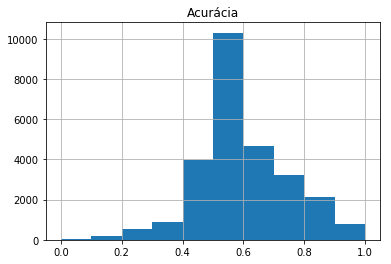

In [17]:
resultadosTecnicas.hist(column='Acurácia')

In [18]:
maiores = resultadosTecnicas.loc[resultadosTecnicas['Acurácia'] >= 0.8]

In [19]:
len(maiores['Ação'].unique())

292

In [20]:
maiores['Ação'].unique()

array(['BBDC3T', 'BGIP4', 'BMEB3', 'BMEB4F', 'BNBR3', 'BRAP4T', 'BRIV3',
       'BRIV4', 'BRSR3F', 'BTOW3T', 'CAMB4F', 'CCRO3T', 'CESP5F', 'CSRN6',
       'CSRN6F', 'ELET3T', 'FNAM11', 'FNAM11F', 'GEPA4', 'GGBR3T',
       'GOAU4T', 'GUAR3T', 'ITSA4T', 'JBSS3T', 'LAME4T', 'PCAR4T',
       'RCSL3F', 'RPAD3', 'SLCE3T', 'SLED3', 'TCSA3T', 'TEKA3F', 'TOYB3F',
       'TOYB4', 'UNIP6T', 'VALE3T', 'BRIV4F', 'BTTL4F', 'CEDO4', 'CTKA4F',
       'DASA3T', 'GUAR4T', 'ITEC3F', 'JOPA3', 'KLBN3F', 'PSSA3T', 'RAPT3F',
       'UNIP3F', 'BIOM3', 'MTSA4F', 'PNVL3', 'RENT3T', 'BRSR3', 'CMIG3T',
       'GEPA4F', 'BTTL3F', 'EALT4F', 'UNIP5F', 'FESA4T', 'TOTS3T',
       'SLED4T', 'TCNO3F', 'BEEF3T', 'PNVL3F', 'RPAD3F', 'CGRA3F', 'GEPA3',
       'PABY11', 'HBOR3T', 'BRSR6T', 'COCE3F', 'SHUL4F', 'BAHI3F',
       'ELPL3F', 'MYPK3T', 'PETRR96', 'TPIS3T', 'IBOVF76', 'PETRF68',
       'PETRF77', 'IBOVF78', 'USIMF88', 'PETRF36', 'USIMF94', 'ITSAF12',
       'ITSAG11', 'BBASF33', 'IBOVH76', 'ITSAG12', 'SGPS3T', 'CSN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3ea90f6a0>]], dtype=object)

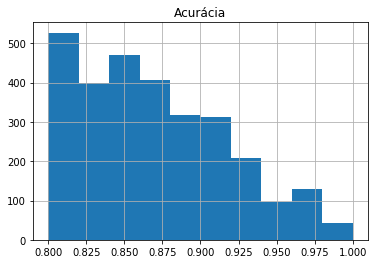

In [21]:
maiores.hist(column='Acurácia')

In [22]:
maiores.loc[maiores['Ação'] == 'VALE3T']

,Ação,Técnica,Acurácia
0,VALE3T,AdaBoostClassifier,0.804087
2,VALE3T,BernoulliNB,0.805288
7,VALE3T,GradientBoostingClassifier,0.805288
9,VALE3T,LinearSVC,0.805288
10,VALE3T,LogisticRegression,0.805288
11,VALE3T,LogisticRegressionCV,0.805288
12,VALE3T,MLPClassifier,0.805288
15,VALE3T,PassiveAggressiveClassifier,0.805288
16,VALE3T,Perceptron,0.805288
18,VALE3T,RidgeClassifier,0.805288


In [23]:
for acao in maiores['Ação'].unique():
    if len(acao) <= 5:
        print(acao)

BGIP4
BMEB3
BNBR3
BRIV3
BRIV4
CSRN6
GEPA4
RPAD3
SLED3
TOYB4
CEDO4
JOPA3
BIOM3
PNVL3
BRSR3
GEPA3
BPAC3
BPAC5
B3SA3
BBRK1


In [24]:
selecionados = [acao for acao in maiores['Ação'].unique()
                        if len(acao) <= 5]
len(selecionados)

20

In [ ]:
teste = retornaDadosAcao('VALE3T')
teste.head()

In [ ]:
X = teste.copy()
X.drop('CODNEG', axis=1, inplace=True)
X.drop('STATUS_POSITIVO', axis=1, inplace=True)
y = teste['STATUS_POSITIVO'] 

In [ ]:
X_train, X_test, y_train, y_test = splitDados(X, y)

In [ ]:
tpot = TPOTClassifier(generations=1, population_size=2, verbosity=2, n_jobs=-1)
#tpot

In [ ]:
start_time = time.time()

tpot.fit(X_train, y_train)

print("---Tempo gasto:  %s segundos ---" % ((time.time() - start_time)))

In [ ]:
y_pred = tpot.predict(X_test)

In [ ]:
avaliarTecnica(y_test, y_pred)

In [ ]:
X_train.as_matrix()

In [37]:
len(tecnicas)

22

In [30]:
from sklearn.base import ClassifierMixin
from sklearn.utils.testing import all_estimators

In [31]:
classifiers=[est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning

In [32]:
classifiers

[('AdaBoostClassifier', sklearn.ensemble.weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble.bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('DecisionTreeClassifier', sklearn.tree.tree.DecisionTreeClassifier),
 ('ExtraTreeClassifier', sklearn.tree.tree.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble.forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('GaussianProcessClassifier',
  sklearn.gaussian_process.gpc.GaussianProcessClassifier),
 ('GradientBoostingClassifier',
  sklearn.ensemble.gradient_boosting.GradientBoostingClassifier),
 ('KNeighborsClassifier',
  sklearn.neighbors.classification.KNeighborsClassifier),
 ('LabelPropagation',
  sklearn.semi_supervised.label_propagation.LabelPropagation),
 ('LabelSpreading', sklearn.semi_supervised.label_propagation.LabelSpreading),
 ('LinearDiscriminantAnalysis',
  sk

In [ ]:
len(classifiers)

In [ ]:
y_train.values.reshape(1, -1)